# blueberry_masks.ipynb

Started by: Sasank Marabattula

smaraba@ncsu.edu

Using SAM and roboflow library with custom code to obtain segmentation masks from bounding boxes of images.


#### CITATION (10/20/2023)

Code snippets derived from Roboflow. Supervision [Computer software]. https://github.com/roboflow/supervision





In [ ]:
!pip install pycocotools
!pip install scipy
!pip install -q roboflow dataclasses-json supervision

In [ ]:
# Warning: Only run if you don't have SAM installed as it will download 2GB model
!pip install git+https://github.com/facebookresearch/segment-anything.git

In [ ]:
import random
import cv2
import os
import torch

import numpy as np
import pandas as pd
import supervision as sv
import roboflow
import json
import time
import math

from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
from roboflow import Roboflow
from scipy import ndimage
from pycocotools.coco import COCO
from segment_anything import sam_model_registry, SamPredictor
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple
from supervision.detection.core import Detections
from supervision.dataset.utils import approximate_mask_with_polygons
from supervision.utils.file import save_json_file



In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'
MODEL_TYPE = "vit_h"

In [ ]:
HOME = os.getcwd()

In [ ]:
# Download SAM Weights into weights directory
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

sam_predictor = SamPredictor(sam)

In [275]:
# Roboflow loading downloaded dataset from local
roboflow.login()
rf = Roboflow()
project = rf.workspace("jeremy-park").project("blueberry_segmentation") #Workspace_name , project_name
dataset = project.version(2).download("coco") # Already downloaded the dataset
dataset_loc = os.path.join(HOME,dataset.name+"-"+dataset.version)


You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to blueberry_segmentation-2 in coco:: 100%|██████████| 299/299 [00:00<00:00, 736.23it/s]


In [5]:
dataset


In [3]:
%ls {dataset_loc}

 Volume in drive C is Acer
 Volume Serial Number is 4C88-CF93

 Directory of c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_segmentation-2

10/20/2023  01:07 PM    <DIR>          .
10/19/2023  12:45 AM    <DIR>          ..
10/20/2023  01:07 PM               971 README.roboflow.txt
10/18/2023  06:03 PM    <DIR>          test
10/18/2023  06:03 PM    <DIR>          train
10/18/2023  06:03 PM    <DIR>          valid
               1 File(s)            971 bytes
               5 Dir(s)  169,928,806,400 bytes free


In [4]:
# Define your constants and variables here, including dataset_loc, ANNOTATIONS_FILE_NAME, sv.DetectionDataset, sam_predictor, segment, etc.
# Make sure times is properly initialized with completed image data

# mask_annotator = sv.MaskAnnotator()
# box_annotator = sv.BoxAnnotator()

# random.seed(2023)

# def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
#     sam_predictor.set_image(image)
#     result_masks = []
#     for box in xyxy:
#         masks, scores, logits = sam_predictor.predict(
#             box=box,
#             multimask_output=False
#         )
#         index = np.argmax(scores)
#         result_masks.append(masks[index])
#     return np.array(result_masks)

# ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
# DATA_SET_SUBDIRECTORY = "valid"
# IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc,DATA_SET_SUBDIRECTORY)
# ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH,ANNOTATIONS_FILE_NAME)



## Testing custom COCO annotations updation

### For sample image

In [261]:

image_name = os.path.join(IMAGES_DIRECTORY_PATH, "NC5313_F2_15_17_jpg.rf.d9f1240bb03e7a7802c899bae5ee408e.jpg")#"H1-18-062_F2_32_4_jpg.rf.555d9ef6fb2a7dad7273df6190561a3a.jpg")

# Initialize the COCO API for your annotation file
coco = COCO(ANNOTATIONS_FILE_PATH)

# Define the image name you want to search for
image_name_only = image_name.split("\\")[-1]

# Create a mapping of image file names to image IDs
image_name_to_id = {img['file_name']: img['id'] for img in coco.dataset['images']}

id_to_image_name = {img['id']: img['file_name'] for img in coco.dataset['images']}


loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [219]:
id_to_image_name


{0: '17-003_F2_23_13_jpg.rf.17c60dbc4691db22ef21abec28e3cbb1.jpg',
 1: 'H1-NC5283_H2_6_5J_jpg.rf.547e9e6559bbbed92ea9a57ade21c356.jpg',
 2: 'H1-NC5288_H2_6_1G_jpg.rf.64a19c9a8620b44941707559b3957817.jpg',
 3: 'H1-NC5285_F2_15_1B_jpg.rf.6f8476b4272e252d77e2577a2fdd9790.jpg',
 4: 'NC5286_F2_15_1_jpg.rf.11c0925e901a66c05efa919105641dbe.jpg',
 5: 'Krewer_F2_19_4_jpg.rf.860790883d50e994f275941e3bae348a.jpg',
 6: 'H1-NC5274_H2_5_6A_jpg.rf.7bf9f831d84e9e698b7f69ee6ca3c9e9.jpg',
 7: 'NC5301_F2_17_17_jpg.rf.2b723c1f1b7d7eb0207f098fefa5408a.jpg',
 8: 'H1-NC5271_H2_1_2I_jpg.rf.7f8020b2ab2cdf8a4dd8fe3b2b1b857a.jpg',
 9: 'H2-NC5331_F2_18_6A_jpg.rf.0fd10e0a79c2ad51b94509d0349c66d9.jpg',
 10: '16-049_F2_32_12_jpg.rf.96e9ce4cdcf9fd0a54b0c943cb3b440f.jpg',
 11: '17-004_22_13_jpg.rf.10e91314a344902b566c916c45b99a7f.jpg',
 12: 'H2-Rebel_E3_7_6F_jpg.rf.b9a66cf30c699bbdac584f9c07a40c2f.jpg',
 13: 'NewHanover3_jpg.rf.37828fa29c30042c7b814fcdbb2adf11.jpg',
 14: 'H1-NC5313_F2_15_17A_jpg.rf.23307b6585ab568b080

In [262]:
def coco_get_img_id(image_name_only):
    image_id = None
    # Check if the image name exists in the mapping
    if image_name_only in image_name_to_id:
        image_id = image_name_to_id[image_name_only]
        print(f"Image ID for '{image_name_only}' is {image_id}")
    else:
        print(f"Image '{image_name_only}' not found in the dataset")
    return image_id


In [263]:
# Specify the image ID for the image you want to retrieve bounding boxes from
image_id = coco_get_img_id(image_name_only)
# Get the annotation IDs for this image
annotation_ids = coco.getAnnIds(imgIds=image_id)

# Get the annotations for this image
annotations = coco.loadAnns(annotation_ids)

# Extract and print bounding boxes
bounding_boxes = np.array([annotation['bbox'] for annotation in annotations])

k = 0
bbox_xyxy = np.array([[np.ceil(x)-k,np.ceil(y)-k,np.ceil(x+w)+k,np.ceil(y+h)+k] for x,y,w,h in bounding_boxes])



Image ID for 'NC5313_F2_15_17_jpg.rf.d9f1240bb03e7a7802c899bae5ee408e.jpg' is 30


In [264]:
result_masks = segment(sam_predictor,cv2.imread(image_name),bbox_xyxy)


In [253]:


# Assuming you have a binary mask represented as True and False values
mask_bool = result_masks[annotation_ids.index(481)]# 3270

# Label connected components
labeled_mask, num_features = ndimage.label(mask_bool)

# Initialize a list to store polygons
polygons = []

# Find and convert contours to polygons
for feature_id in range(1, num_features + 1):
    component_mask = labeled_mask == feature_id
    contours, _ = cv2.findContours(component_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        epsilon = 1  # Adjust epsilon as needed
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(polygon)

# Now, 'polygons' contains the segmentation polygons

#(1983.0, 1482.0), (2153.15, 1631.48)


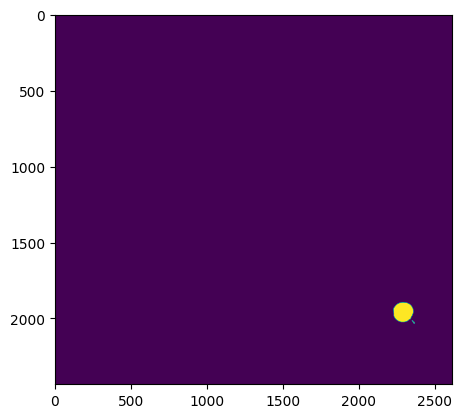

In [254]:
# Create a binary image (CV_8UC1 format) with 0s and 255s
mask_binary = np.uint8(mask_bool) * 255
plt.imshow(mask_binary)


In [151]:
def find_blueberry_polygons(mask_bool):
    mask_binary = np.uint8(mask_bool) * 255  # Convert True to 255, False to 0
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    ans = []
    polygons = []
    for obj in contours:
        coords = []

        for point in obj:
            coords.append(int(point[0][0]))
            coords.append(int(point[0][1]))
        print(coords)
        ans.append(coords)
    for i in ans:
        polygons.extend(ans)
    return polygons


In [42]:
import cv2
contours, _ = cv2.findContours(anomaly, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

polygons = [cv2.approxPolyDP(contour, 10.0, closed=True) for contour in contours]



error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [265]:
anomaly = []
# for i in range(len(annotation_ids)):
# print(i,(annotations[i]['segmentation'])[0])

# for i,binary_mask in enumerate(result_masks):
#     res = (list(approximate_mask_with_polygons(
#                     mask=binary_mask,
#                     min_image_area_percentage=0.0,
#                     max_image_area_percentage=1.0,
#                     approximation_percentage=0.0,
#                 )[0].flatten()))

#     # actual = annotations[i]['segmentation'][0]
#     # print(annotations[i]['id'])
#     # if not sorted(actual) == sorted(res):
#     #     print(len(res),sorted(actual) - sorted(res))
with open(ANNOTATIONS_FILE_PATH, 'r') as f:
    coco_data = json.load(f)
# Update annotations
for annotation_id,bbox,mask in zip(annotation_ids,bounding_boxes,result_masks):
    print(annotation_id)
    res_polygons = approximate_mask_with_polygons(
                mask=mask,
                min_image_area_percentage=0.0,
                max_image_area_percentage=1.0,
                approximation_percentage=0.0,
            )
    # print(np.array(res_polygons).shape) #481
    # Initialize an empty list to store the flattened elements
    # res0 = []
    # # Loop through the list of numpy arrays and extract the individual elements
    # for polygon in res_polygons:
    #     for point in polygon:
    #         res0.extend(list(point))

    # if (annotation_id) in [481]:
    #      anomaly = res_polygons
    #      print(annotation_id,np.array(res_polygons).shape)
    #      print(res_polygons)

    res0 = max(res_polygons, key=len).flatten()

    # res0 = list(res_polygons[0].flatten())
    # Convert them into int as NumPy datatype intc can't be JSON serializable,
    # This fixes the error while saving the json file
    res = [int(i) for i in res0]
    # for i in range(0,len(res),2):
    #    if not (bbox[0]<=res[i]<=bbox[0] + bbox[2]):
    #     #print(annotation_id,(bbox[0]<=res[i]<=bbox[0] + bbox[2]),(bbox[1]<=res[i+1]<=bbox[1] + bbox[3]))
    #         print(annotation_id,((bbox[0],bbox[1]),(bbox[2] + bbox[0],bbox[3] + bbox[1])),res[i],res[i+1])
    # # Update the 'segmentation' field
    if (coco_data['annotations'][annotation_id]['image_id'] == image_id and (coco_data['annotations'][annotation_id]['bbox'] == bbox).all()):
        coco_data['annotations'][annotation_id]['segmentation'] = [res]
    else:
        print("Incorrect bbox or image")
        if (coco_data['annotations'][annotation_id]['image_id'] != image_id):
            print("expected image_id processing="+str(image_id)+" but in coco_data got "+str(coco_data['annotations'][annotation_id]['image_id']))
        print("Expected:",coco_data['annotations'][annotation_id-1])
        print("But processing",annotation_id,bbox)
        break

with open(ANNOTATIONS_FILE_PATH, 'w') as f:
    json.dump(coco_data, f)


3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784


In [193]:
def classes_to_coco_categories(classes: List[str]) -> List[dict]:
    return [
        {
            "id": class_id,
            "name": class_name,
            "supercategory": "common-objects",
        }
        for class_id, class_name in enumerate(classes)
    ]


In [276]:
DATA_DIRECTORIES = ['test', 'train', 'valid']
dataset_loc = dataset_loc

ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
NEW_ANNOTATIONS_FILE_NAME = "_annotations_new.coco.json"

min_image_area_percentage = 0.0
max_image_area_percentage = 1.0
approximation_percentage = 0.75

for DATA_SET_SUBDIRECTORY in ["test"]:
    IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc,DATA_SET_SUBDIRECTORY)
    ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH,ANNOTATIONS_FILE_NAME)

    # Initialize the COCO API for your annotation file
    coco = COCO(ANNOTATIONS_FILE_PATH)

    with open(ANNOTATIONS_FILE_PATH, 'r') as f:
        coco_data = json.load(f)
    # Create a mapping of image file names to image IDs
    image_name_to_id = {img['file_name']: img['id'] for img in coco.dataset['images']}

    Path(NEW_ANNOTATIONS_FILE_NAME).parent.mkdir(parents=True, exist_ok=True)
    info = {}
    licenses = [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0",
        }
    ]
    coco_annotations = []
    coco_images = []
    coco_categories = classes_to_coco_categories(classes=[i['name'] for i in coco_data['categories']])

    for image_name,image_id in image_name_to_id.items():
        time_start = time.time()
        # Get the annotation IDs for this image
        annotation_ids = coco.getAnnIds(imgIds=image_id)

        # Get the annotations for this image
        annotations = coco.loadAnns(annotation_ids)
        # Extract bbox xyxy values
        k = 0
        bounding_boxes = np.array([annotation['bbox'] for annotation in annotations])
        bbox_xyxy = np.array([[x-k,y-k,x+w+k,y+h+k] for x,y,w,h in bounding_boxes])

        # Get Binary Masks from SAMPredictor
        result_masks = segment(sam_predictor,cv2.imread(os.path.join(IMAGES_DIRECTORY_PATH,image_name)),bbox_xyxy)

        class_ids = np.array([ann['category_id'] for ann in annotations])

        coco_img_annotations = []
        for annotation_id,xyxy,mask,class_id in zip(annotation_ids,bbox_xyxy,result_masks,class_ids):
            box_width, box_height = xyxy[2] - xyxy[0], xyxy[3] - xyxy[1]
            res_polygons = approximate_mask_with_polygons(
                        mask=mask,
                        min_image_area_percentage=0.0,
                        max_image_area_percentage=1.0,
                        approximation_percentage=0.0,
                    )

            # Pick max point contour
            res0 = max(res_polygons, key=len).flatten()

            # Convert them into int as NumPy datatype intc can't be JSON serializable,
            # This fixes the error while saving the json file
            polygon = [int(val) for val in res0]

            coco_img_annotation = {
            "id": annotation_id,
            "image_id": image_id,
            "category_id": int(class_id),
            "bbox": [xyxy[0], xyxy[1], box_width, box_height],
            "area": box_width * box_height,
            "segmentation": [polygon] if polygon else [],
            "iscrowd": 0,
        }
            coco_img_annotations.append(coco_img_annotation)

        # detections = Detections(xyxy = bbox_xyxy, mask = result_masks, confidence = None, class_id = class_ids,tracker_id = None )
        # coco_annotation, annotation_id = detections_to_coco_annotations(
        #     detections=detections,
        #     image_id=image_id,
        #     annotation_id=annotation_id,
        #     min_image_area_percentage=min_image_area_percentage,
        #     max_image_area_percentage=max_image_area_percentage,
        #     approximation_percentage=approximation_percentage,
        # )

        image_height, image_width = result_masks[0].shape
        coco_image = {
            "id": image_id,
            "license": 1,
            "file_name": image_name,
            "height": image_height,
            "width": image_width,
            "date_captured": datetime.now().strftime("%m/%d/%Y,%H:%M:%S"),
        }

        coco_images.append(coco_image)
        coco_annotations.extend(coco_img_annotations)
        time_end = time.time()
        times[DATA_SET_SUBDIRECTORY][image_name] = time_end - time_start
        print(DATA_SET_SUBDIRECTORY,image_name,image_id,times[DATA_SET_SUBDIRECTORY][image_name])

    annotation_dict = {
        "info": info,
        "licenses": licenses,
        "categories": coco_categories,
        "images": coco_images,
        "annotations": coco_annotations,
    }

    save_json_file(annotation_dict, file_path=os.path.join(IMAGES_DIRECTORY_PATH,NEW_ANNOTATIONS_FILE_NAME))




loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
test 17-003_F2_23_13_jpg.rf.17c60dbc4691db22ef21abec28e3cbb1.jpg 0 10.175500631332397
test H1-NC5283_H2_6_5J_jpg.rf.547e9e6559bbbed92ea9a57ade21c356.jpg 1 12.49030089378357
test H1-NC5288_H2_6_1G_jpg.rf.64a19c9a8620b44941707559b3957817.jpg 2 10.158868551254272
test H1-NC5285_F2_15_1B_jpg.rf.6f8476b4272e252d77e2577a2fdd9790.jpg 3 10.57033371925354
test NC5286_F2_15_1_jpg.rf.11c0925e901a66c05efa919105641dbe.jpg 4 12.163857460021973
test Krewer_F2_19_4_jpg.rf.860790883d50e994f275941e3bae348a.jpg 5 8.291226387023926
test H1-NC5274_H2_5_6A_jpg.rf.7bf9f831d84e9e698b7f69ee6ca3c9e9.jpg 6 8.532060861587524
test NC5301_F2_17_17_jpg.rf.2b723c1f1b7d7eb0207f098fefa5408a.jpg 7 9.242122173309326
test H1-NC5271_H2_1_2I_jpg.rf.7f8020b2ab2cdf8a4dd8fe3b2b1b857a.jpg 8 9.08539080619812
test H2-NC5331_F2_18_6A_jpg.rf.0fd10e0a79c2ad51b94509d0349c66d9.jpg 9 9.608049631118774
test 16-049_F2_32_12_jpg.rf.96e9ce4cdcf9fd0a54b0c943c

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
Image ID for 'H1-NC5285_F2_15_1B_jpg.rf.6f8476b4272e252d77e2577a2fdd9790.jpg' is 3


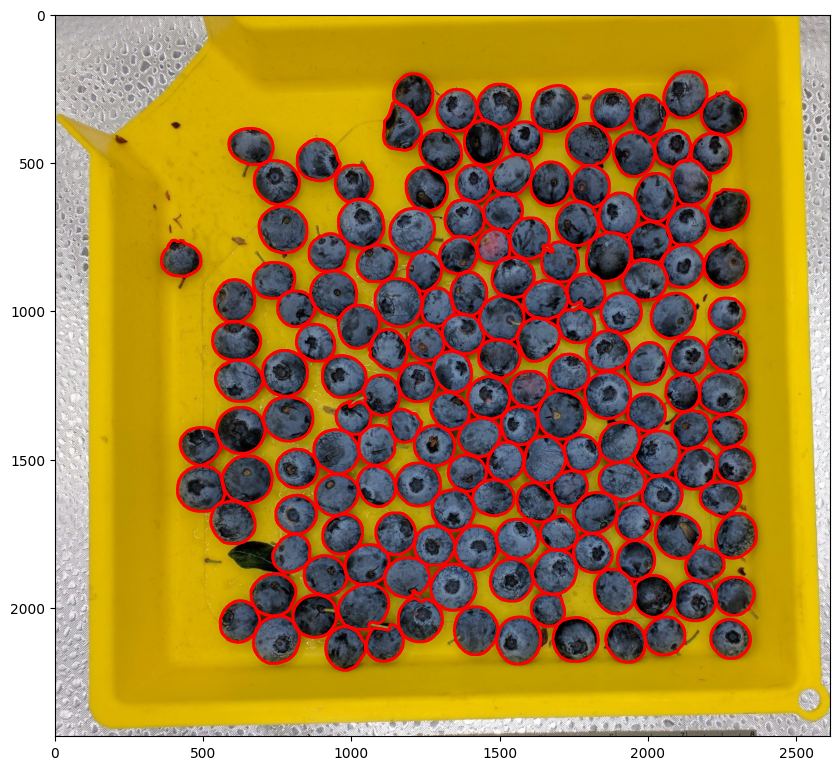

In [266]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

from pycocotools.coco import COCO

image_name = os.path.join(IMAGES_DIRECTORY_PATH, "H1-NC5285_F2_15_1B_jpg.rf.6f8476b4272e252d77e2577a2fdd9790.jpg")#"H1-18-062_F2_32_4_jpg.rf.555d9ef6fb2a7dad7273df6190561a3a.jpg")

# Initialize the COCO API for your annotation file
coco = COCO(ANNOTATIONS_FILE_PATH)

# Define the image name you want to search for
image_name_only = image_name.split("\\")[-1]

# Create a mapping of image file names to image IDs
image_name_to_id = {img['file_name']: img['id'] for img in coco.dataset['images']}

id_to_image_name = {img['id']: img['file_name'] for img in coco.dataset['images']}

image = plt.imread(image_name)

# Specify the image ID for the image you want to retrieve bounding boxes from
image_id = coco_get_img_id(image_name_only)
# Get the annotation IDs for this image
annotation_ids = coco.getAnnIds(imgIds=image_id)

# Get the annotations for this image
annotations = coco.loadAnns(annotation_ids)

# Create a matplotlib figure and axis
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
count = 1
# Iterate through annotations and draw polygons
for annotation in annotations:

    segmentation = annotation['segmentation'][0]  # We assume only one segmentation for simplicity
    poly = [segmentation[i:i+2] for i in range(0, len(segmentation), 2)]
    poly = Polygon(poly, edgecolor='r', facecolor='none', linewidth=2)
    ax.add_patch(poly)

plt.show()


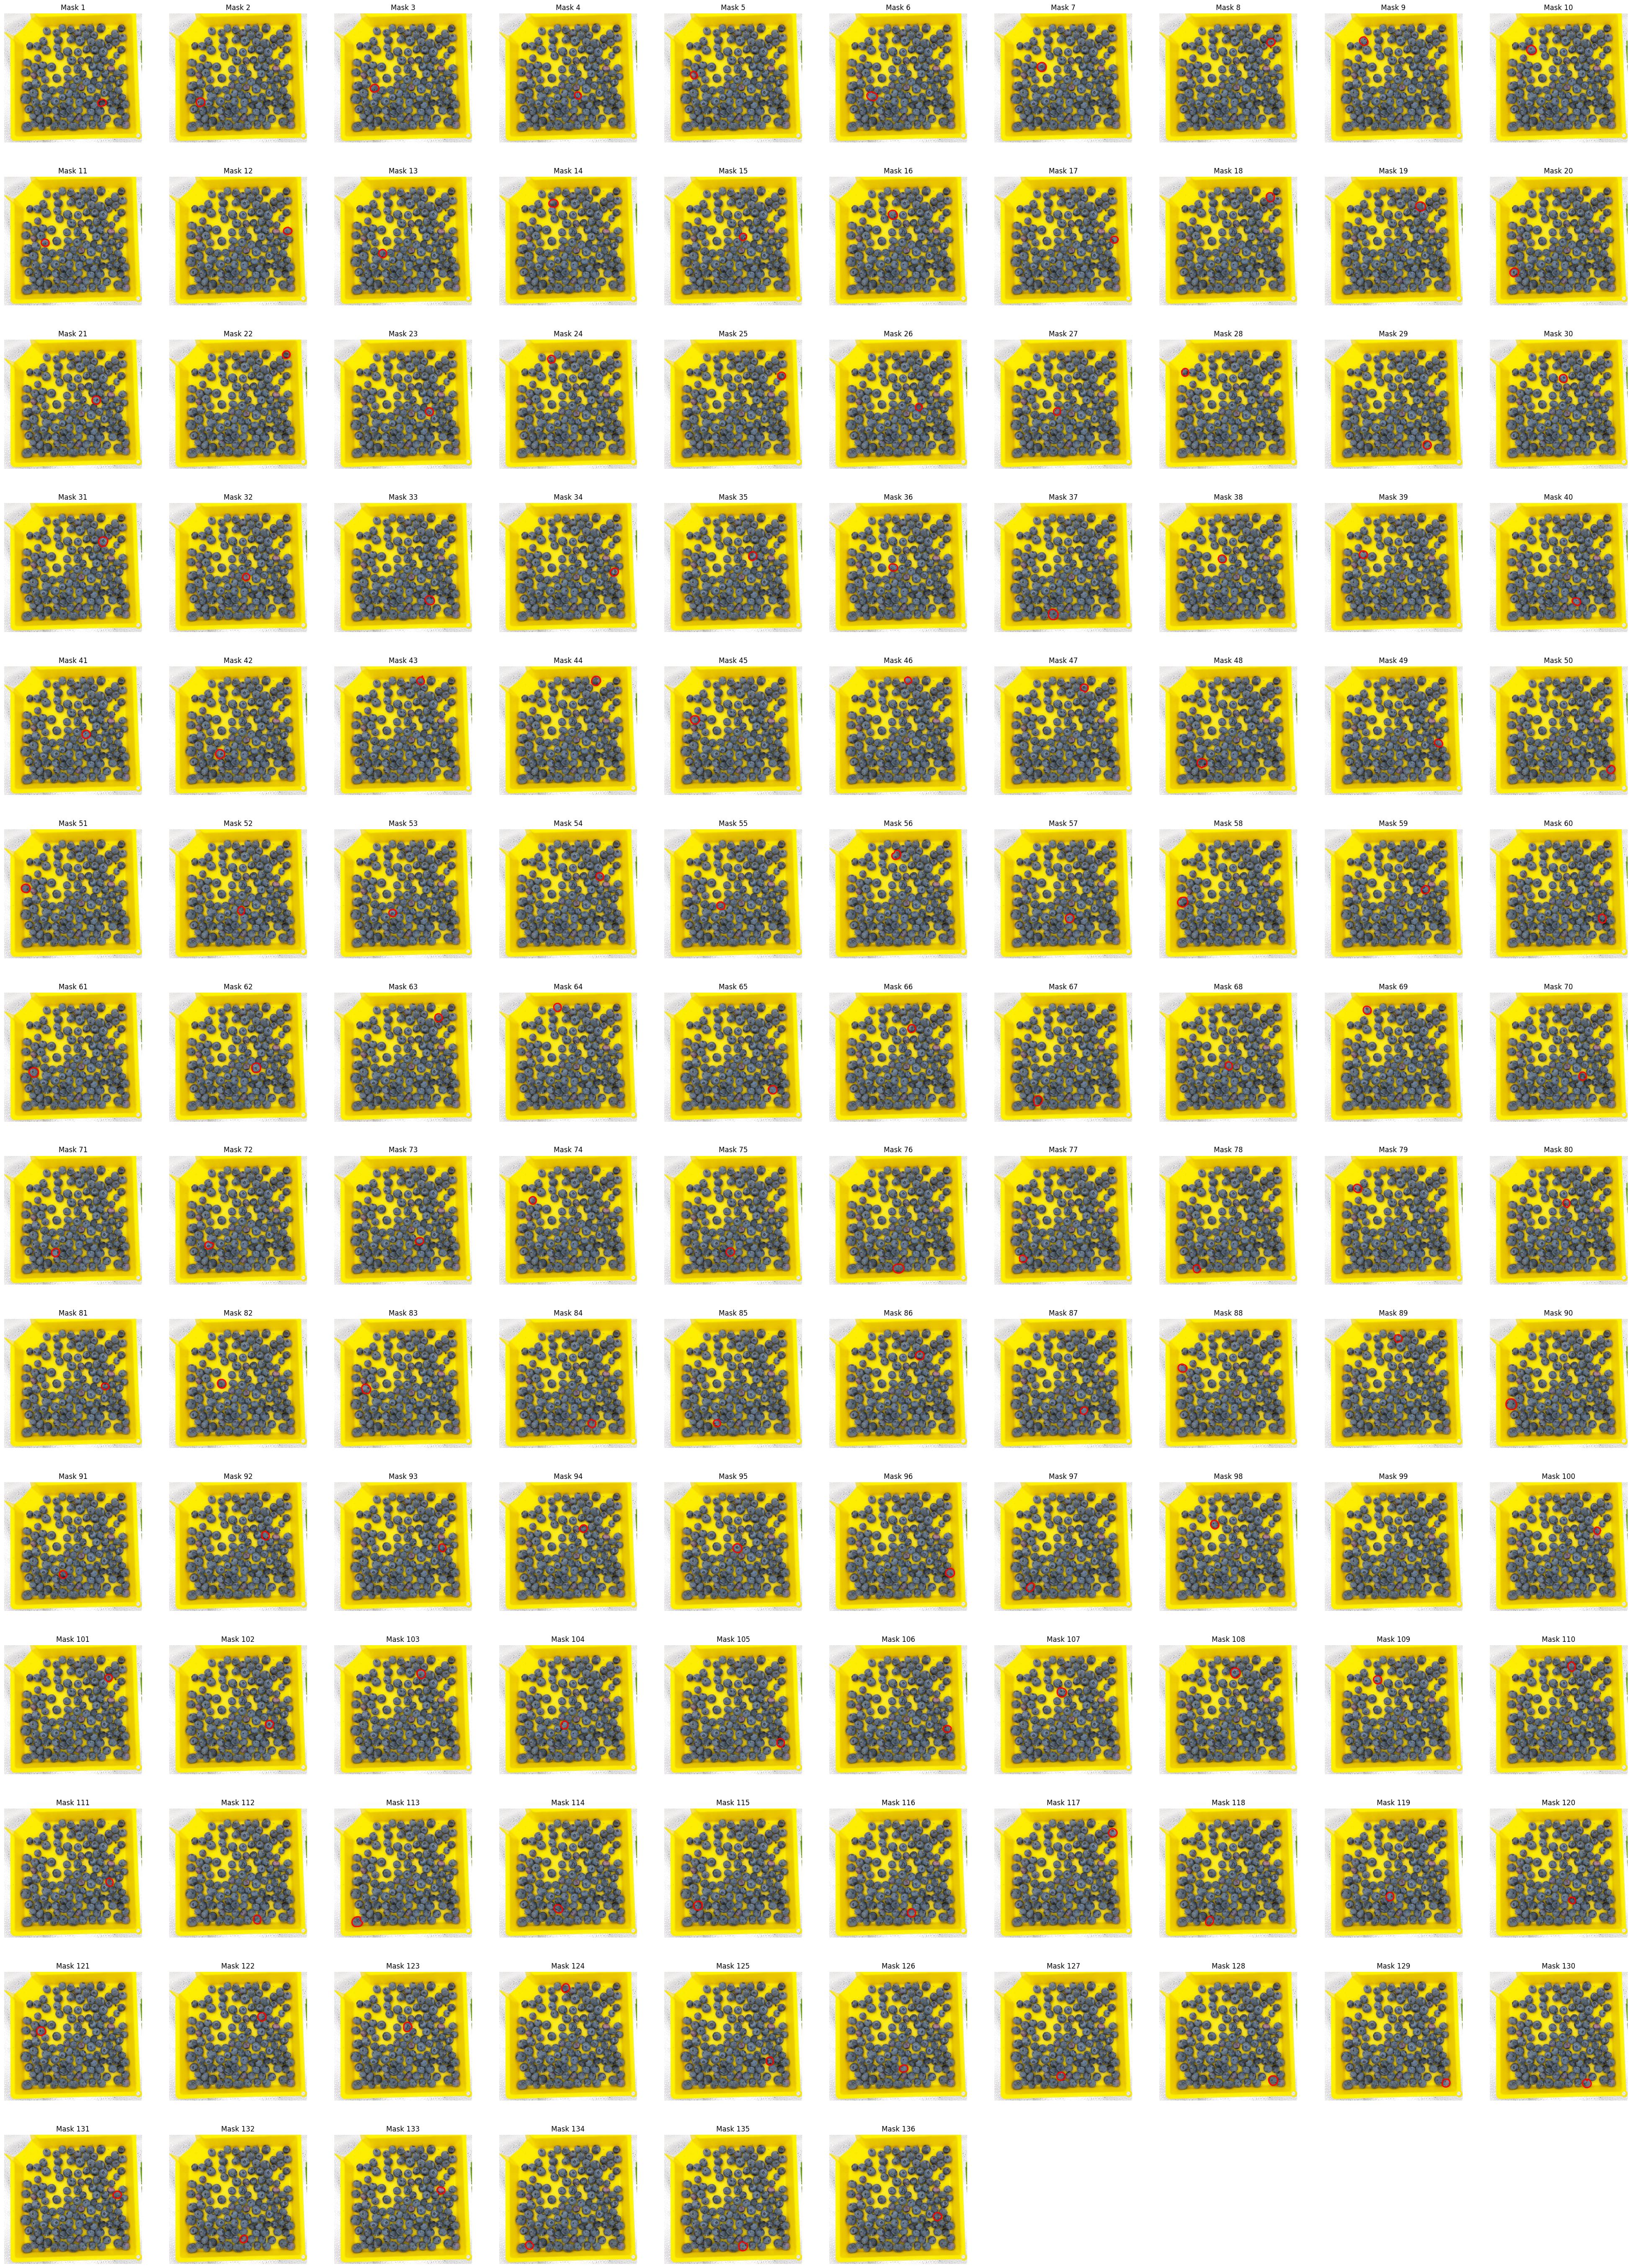

In [67]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

# Load your image (assuming you have it)
image = plt.imread(image_name)

# Determine the number of masks to plot
num_masks = len(annotations)

# Set the maximum number of columns you want in the grid
max_columns = 10  # Adjust this as needed

# Calculate the number of rows and columns in the grid
num_rows = (num_masks + max_columns - 1) // max_columns
num_cols = min(num_masks, max_columns)

# Create a matplotlib figure and axis with the adjusted grid size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

# Flatten the axes array if it's more than 1D
if num_rows > 1:
    axes = axes.flatten()
count = 1
# Iterate through annotations and draw polygons on separate subplots
for i, annotation in enumerate(annotations):
    ax = axes[i]
    segmentation = annotation['segmentation'][0]  # We assume only one segmentation for simplicity
    poly = [segmentation[i:i+2] for i in range(0, len(segmentation), 2)]
    poly = Polygon(poly, edgecolor='r', facecolor='none', linewidth=2)
    ax.imshow(image)  # Show the image on this subplot
    ax.add_patch(poly)
    ax.set_title(f'Mask {i+1}')
    ax.axis('off')


# Hide any remaining empty subplots
for i in range(num_masks, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.show()


### Custom code for all Images to obtain masks from bboxes

In [187]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

def times_maintenance():
    df = pd.read_csv("completed_list.csv", header=None, delimiter=',')
    # Create a dictionary of dictionaries
    result_dict = {'test': {}, 'train': {}, 'valid': {}}

    file_names = []

    # Iterate through the DataFrame and populate the inner dictionaries
    for index, row in df.iterrows():
        print(index,row)
        if not isinstance(row[0], str):
            file_names = row[1:]
        else:
            type =  row[0].lower()
            for img_name, time in zip(file_names, row[1:]):
                print(img_name,time)
                if not math.isnan(float(time)):
                    result_dict[type][img_name] = float(time)
    del file_names
    return result_dict

times = times_maintenance()
times = {'test': {}, 'train': {}, 'valid': {}}


0 0    test
Name: 0, dtype: object
1 0    train
Name: 1, dtype: object
2 0    valid
Name: 2, dtype: object


In [278]:
DATA_DIRECTORIES = ['test', 'train', 'valid']
dataset_loc = dataset_loc

ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

for DATA_SET_SUBDIRECTORY in ['train']:
    IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc,DATA_SET_SUBDIRECTORY)
    ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH,ANNOTATIONS_FILE_NAME)

    # Initialize the COCO API for your annotation file
    coco = COCO(ANNOTATIONS_FILE_PATH)

    # Create a mapping of image file names to image IDs
    image_name_to_id = {img['file_name']: img['id'] for img in coco.dataset['images']}

    with open(ANNOTATIONS_FILE_PATH, 'r') as f:
        coco_data = json.load(f)

    for image_name,image_id in image_name_to_id.items():
        img_stop_flag = 0
        time_start = time.time()
        # Get the annotation IDs for this image
        annotation_ids = coco.getAnnIds(imgIds=image_id)

        # Get the annotations for this image
        annotations = coco.loadAnns(annotation_ids)
        # Extract bbox xyxy values
        bounding_boxes = np.array([annotation['bbox'] for annotation in annotations])
        bbox_xyxy = np.array([[x,y,x+w,y+h] for x,y,w,h in bounding_boxes])

        # Get Binary Masks from SAMPredictor
        result_masks = segment(sam_predictor,cv2.imread(os.path.join(IMAGES_DIRECTORY_PATH,image_name)),bbox_xyxy)

        # Update annotations
        for annotation_id,bbox,mask in zip(annotation_ids,bounding_boxes,result_masks):
            res_polygons = approximate_mask_with_polygons(
                        mask=mask,
                        min_image_area_percentage=0.0,
                        max_image_area_percentage=1.0,
                        approximation_percentage=0.75,
                    ) # [0].flatten()) # Commented as sometimes polygons have other objects other than blueberries

            # Pick max point contour
            res0 = max(res_polygons, key=len).flatten()

            # Convert them into int as NumPy datatype intc can't be JSON serializable,
            # This fixes the error while saving the json file
            res = [int(val) for val in res0]
            # Update the 'segmentation' field
            if (coco_data['annotations'][annotation_id]['image_id'] == image_id and (coco_data['annotations'][annotation_id]['bbox'] == bbox).all()):
                coco_data['annotations'][annotation_id]['segmentation'] = [res]
            else:
                img_stop_flag = 1
                print("Incorrect bbox or image for "+image_name+" annotation_id: ",annotation_id)
                if (coco_data['annotations'][annotation_id]['image_id'] != image_id):
                    print("expected image_id processing="+str(image_id)+" but in coco_data got "+str(coco_data['annotations'][annotation_id]['image_id']))
                print("expected bbox processing="+str(bbox)+" but in coco_data got "+str(coco_data['annotations'][annotation_id]['bbox']))
                break
        time_end = time.time()
        if img_stop_flag:
            print("***CHECK MISMATCH ERROR!!****")
            break
        times[DATA_SET_SUBDIRECTORY][image_name] = time_end - time_start
        print(DATA_SET_SUBDIRECTORY,image_name,image_id,times[DATA_SET_SUBDIRECTORY][image_name])

    with open(ANNOTATIONS_FILE_PATH, 'w') as f:
        json.dump(coco_data, f)




loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
train NC5271_H2_7_5_jpg.rf.f852783ecd4d97730b14b55ea66c1f0b.jpg 0 10.655434846878052
train NC5271_jpg.rf.fc1ebf0242564ad3c40239a417cfa8b4.jpg 1 8.894164323806763
train H2-NC5275_H2_5_3A_jpg.rf.f8faa3fcd5ea42d03c2b60c38d1b6f87.jpg 2 9.376170873641968
train H1-O_Neal_E3_7_43-48D_jpg.rf.f94bf4f2bb8e9075f1f5c0be0b3cd5a7.jpg 3 10.095951795578003
train NCV-17-2_F2_26_12_jpg.rf.fabc5865a57288c03e25f17df530d9a2.jpg 4 9.092653036117554
train H1-18-063_F2_30_1_jpg.rf.f8008f6b0ed775cd51d1e68f120b2d3c.jpg 5 7.950990200042725
train NC5297_F2_16_13_jpg.rf.f92d1f56df052ab498520b9a075d5e23.jpg 6 10.115160465240479
train NC5283_F2_16_14_jpg.rf.fcf998cb104d3037473b8002435d2ee5.jpg 7 14.553802728652954
train H1-O_Neal_H2_6_6D_jpg.rf.fcfa37a1c944354e3d22c84e6ec5525a.jpg 8 9.488261938095093
train H2-17-010_F2_22_18_jpg.rf.059e95983d054fbac7732401f7c12745.jpg 9 9.412219762802124
train NC5280_F2_13_21_jpg.rf.0557e218c9ee534d77

In [7]:
import csv

# Define the CSV file name
csv_file = "time_charts.csv"

# Define the field names for the CSV file
fieldnames = ["split", "file_name", "time_processed"]

# Open the CSV file for writing
with open(csv_file, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    # Write the header row
    writer.writeheader()

    # Write the data
    for split, inner_dict in times.items():
        for file_name, time_processed in inner_dict.items():
            row = {"split": split, "file_name": file_name, "time_processed": time_processed}
            writer.writerow(row)

print("Data saved to", csv_file)


Data saved to time_charts.csv
